In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from numba import jit #for speed up, we use jit compile

In [2]:
#Parameters for calculation
L=16
Tc = 2.0/np.log(1.0+np.sqrt(2.0))
T=Tc
N=L*L
J=1.0

thermalization = 10000
observation = 10000
correlation_time = 100

algorithm="metropolis"
#algorithm="heatbath"

In [3]:
@jit
def metropolis(S,exps):
    ran = np.random.rand(N).reshape(L,L)
    for ix in range(L):
        for iy in range(L):
            h = (S[ix,iy]*(S[(ix + 1)%L,iy] + S[ix,(iy + 1)%L] + S[(ix - 1 + L)%L,iy] + S[ix,(iy - 1 + L )%L]) + 4)/2
            if ran[ix,iy] < exps[h]:
                S[ix,iy] *= -1
    return S


In [4]:
@jit
def heatbath(S,exps):
    ran = np.random.rand(N).reshape(L,L)
    for ix in range(L):
        for iy in range(L):
            h = ((S[(ix + 1)%L,iy] + S[ix,(iy + 1)%L] + S[(ix - 1 + L)%L,iy] + S[ix,(iy - 1 + L )%L]) + 4)/2
            if ran[ix,iy] < exps[h]:
                S[ix,iy] = 1
            else:
                S[ix,iy] = -1
    return S


In [5]:
def MC(S,T,thermalization,observation,algorithm="metropolis"):
    exps=np.zeros(5)        

    if algorithm=="heatbath":
        for i in range(5):
            h = -4.0 + 2.0*i            
            exps[i]= 1.0/(1.0 + np.exp(-2.0*J/T * h))
    else:
        for i in range(5):
            h = -4.0 + 2.0*i            
            exps[i]= np.exp(-2.0*J/T * h)


        
    for i in range(thermalization):
        if algorithm=="heatbath":
            S = heatbath(S,exps)
        else:
            S = metropolis(S,exps)

    mag = []
    mag2 = []
    ene = []
    ene2 = []
    for i in range(observation):
        if algorithm=="heatbath":
            S = heatbath(S,exps)
        else:
            S = metropolis(S,exps)        
        local_mag = np.sum(S) / float(N)
        mag.append(local_mag)
        mag2.append(local_mag**2)
        local_ene = 0.0
        for ix in range(L):
            for iy in range(L):
                local_ene += S[ix,iy] * (S[(ix + 1)%L ,iy] + S[ix,(iy + 1)%L])

        local_ene /= float(N)
        ene.append(local_ene)
        ene2.append(local_ene**2)

    mag = np.array(mag)
    mag2 = np.array(mag2)
    ene = -J * np.array(ene)
    ene2 = J*J * np.array(ene2)
    return mag,mag2,ene,ene2,S


In [6]:
## Initialization and run simulation
S = np.random.choice([-1,1],N).reshape(L,L)
mag, mag2, ene,ene2,S = MC(S,T,thermalization,observation,algorithm)

In [7]:
## output average

print ("T = ")+ repr(T)
print ("Energy = ") + repr(ene.mean())
print ("Energy^2 = ") + repr(ene2.mean())
print ("Magnetization = ") + repr(mag.mean())
print ("Magnetization^2 = ") + repr(mag2.mean())
print ("Specific heat = ") + repr((ene2.mean()-(ene.mean())**2)/T**2*N)

T = 2.269185314213022
Energy = -1.4566828125
Energy^2 = 2.1520981201171874
Magnetization = 0.3019515625
Magnetization^2 = 0.5511686889648437
Specific heat = 1.500109300240305


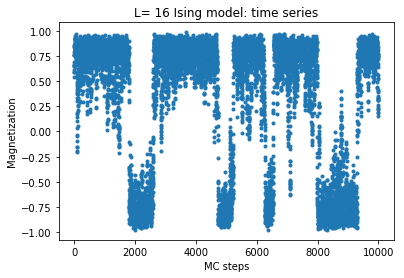

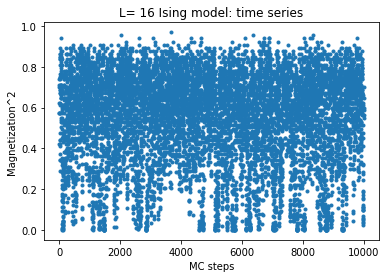

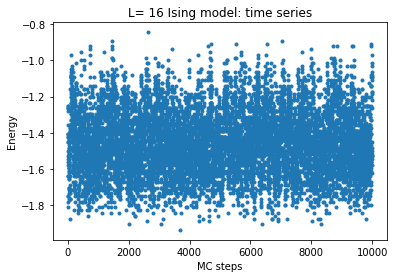

In [8]:
## plot time series

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Magnetization")
pyplot.plot(np.arange(mag.size),mag,".")

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Magnetization^2")
pyplot.plot(np.arange(mag2.size),mag2,".")

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(ene.size),ene,".")

pyplot.show()

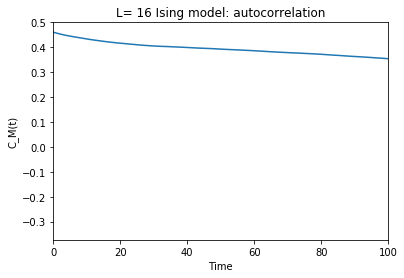

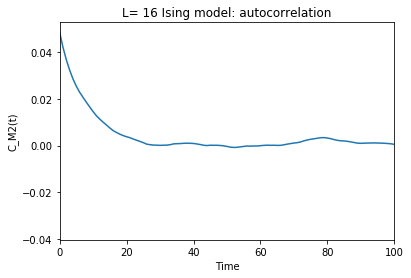

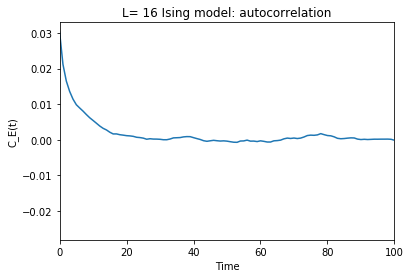

In [10]:
## plot autocorrelation
mag_d = mag - mag.mean()
mag2_d = mag2 - mag2.mean()
ene_d = ene - ene.mean()

cor_mag = np.correlate(mag_d,mag_d,mode="full")
cor_mag = cor_mag[cor_mag.size/2:]/np.arange(mag_d.size,0,-1)
cor_mag2 = np.correlate(mag2_d,mag2_d,mode="full")
cor_mag2 = cor_mag2[cor_mag2.size/2:]/np.arange(mag2_d.size,0,-1)
cor_ene = np.correlate(ene_d,ene_d,mode="full")
cor_ene = cor_ene[cor_ene.size/2:]/np.arange(ene_d.size,0,-1)



pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_M(t)")
pyplot.plot(np.arange(cor_mag.size),cor_mag)
pyplot.xlim([0,correlation_time])

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_M2(t)")
pyplot.plot(np.arange(cor_mag2.size),cor_mag2)
pyplot.xlim([0,correlation_time])

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_E(t)")
pyplot.plot(np.arange(cor_ene.size),cor_ene)
pyplot.xlim([0,correlation_time])

pyplot.show()